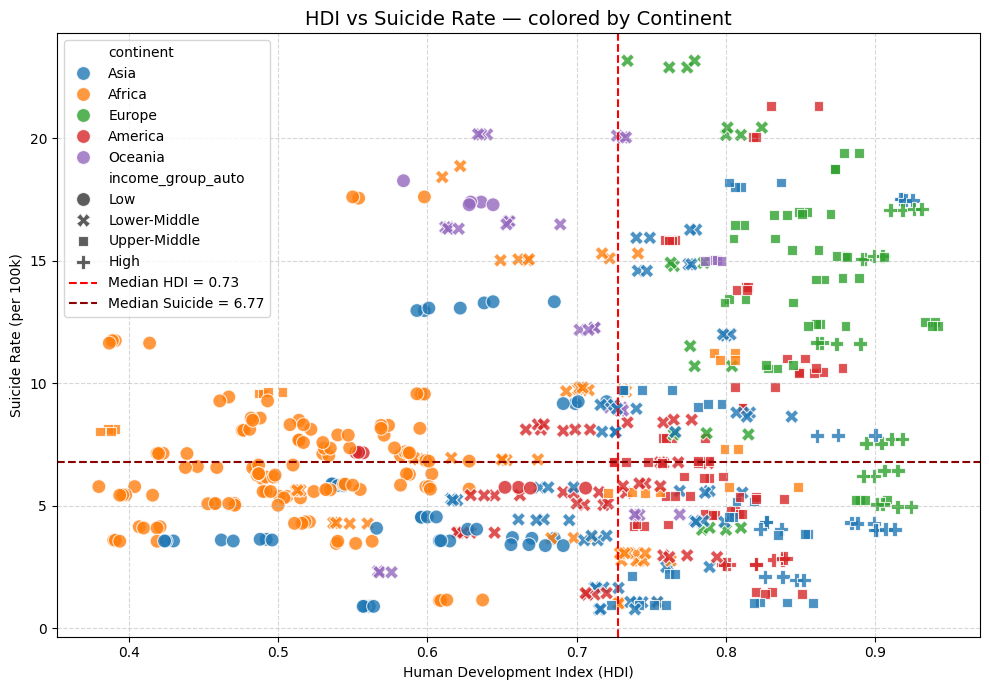

✅ Slide 1 saved as slide1_scatter_hdi_suicide.png


✅ Slide 2 saved as slide2_world_map_focus.png


IndexError: index 0 is out of bounds for axis 0 with size 0

In [1]:
# generate_visualizations.py
# Create exportable visualizations for "The Price of Progress"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.formula.api as smf
import os

# ================
# Load dataset
# ================
DATA_PATH = "./final_dataset.csv"  # adjust path if needed
EXPORT_DIR = "exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# numeric cleaning
for c in ["HDI", "Suicide_rate", "log_GDP_per_capita", "GDP_per_capita"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["HDI", "Suicide_rate"])

# ================
# Slide 1: Scatter plot
# ================
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df,
    x="HDI",
    y="Suicide_rate",
    hue="continent",
    style="income_group_auto",
    s=100,
    alpha=0.8
)
plt.title("HDI vs Suicide Rate — colored by Continent", fontsize=14)
plt.xlabel("Human Development Index (HDI)")
plt.ylabel("Suicide Rate (per 100k)")
plt.grid(True, linestyle="--", alpha=0.5)

# red threshold lines
hdi_thresh = df["HDI"].median()
suicide_thresh = df["Suicide_rate"].median()
plt.axvline(hdi_thresh, color="red", linestyle="--", label=f"Median HDI = {hdi_thresh:.2f}")
plt.axhline(suicide_thresh, color="darkred", linestyle="--", label=f"Median Suicide = {suicide_thresh:.2f}")
plt.legend()

plt.tight_layout()
plt.savefig(f"{EXPORT_DIR}/slide1_scatter_hdi_suicide.png", dpi=300)
plt.show()

print("✅ Slide 1 saved as slide1_scatter_hdi_suicide.png")

# ================
# Slide 2: World map + focus countries
# ================
map_year = df["Year"].max()
df_map = df[df["Year"] == map_year]

fig_map = px.choropleth(
    df_map,
    locations="ISO3",
    color="Suicide_rate",
    hover_name="Country Name",
    color_continuous_scale="Reds",
    title=f"Global Suicide Rate Map ({map_year})"
)
fig_map.update_layout(height=600)

# highlight two focus countries (example: South Korea, Lithuania)
focus_countries = ["South Korea", "Lithuania"]
df_focus = df_map[df_map["Country Name"].isin(focus_countries)]

for _, row in df_focus.iterrows():
    fig_map.add_scattergeo(
        locations=[row["ISO3"]],
        text=f"{row['Country Name']}: {row['Suicide_rate']:.1f}",
        mode="text+markers",
        marker=dict(size=10, color="blue"),
        name=row["Country Name"]
    )

fig_map.write_image(f"{EXPORT_DIR}/slide2_world_map_focus.png", scale=2, width=1200, height=700)
fig_map.show()

print("✅ Slide 2 saved as slide2_world_map_focus.png")

# Explain standout countries
for c in focus_countries:
    val = df_focus.loc[df_focus["Country Name"] == c, "Suicide_rate"].values[0]
    print(f"ℹ️ {c} stands out with a high suicide rate ({val:.1f} per 100k).")

# ================
# Slide 3: Future projections (model prediction)
# ================
# Quadratic model
formula = "Suicide_rate ~ HDI + I(HDI**2) + log_GDP_per_capita"
model = smf.ols(formula, data=df).fit()
print(model.summary())

# Predict 50 years ahead for countries with highest suicide rate
top_countries = df.groupby("Country Name")["Suicide_rate"].mean().sort_values(ascending=False).head(2).index.tolist()

predictions = []
for c in top_countries:
    df_c = df[df["Country Name"] == c].sort_values("Year")
    if df_c.empty:
        continue
    last = df_c.iloc[-1]
    hdi0 = last["HDI"]
    gdp0 = last["GDP_per_capita"]
    loggdp0 = last["log_GDP_per_capita"]

    for i in range(1, 51):  # project 50 years
        year = last["Year"] + i
        hdi = min(hdi0 + 0.002 * i, 1.0)
        gdp = gdp0 * (1.03 ** i)
        loggdp = np.log(gdp)
        pred = model.predict(pd.DataFrame({"HDI": [hdi], "HDI_sq": [hdi**2], "log_GDP_per_capita": [loggdp]}))[0]
        predictions.append({"Country": c, "Year": year, "Predicted_Suicide_rate": pred})

df_pred = pd.DataFrame(predictions)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pred, x="Year", y="Predicted_Suicide_rate", hue="Country", palette="tab10")
plt.title("Projected Suicide Rate (next 50 years) — 'Bad Future' scenario")
plt.ylabel("Predicted Suicide Rate (per 100k)")
plt.xlabel("Year")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(f"{EXPORT_DIR}/slide3_future_projection.png", dpi=300)
plt.show()

print("✅ Slide 3 projection saved as slide3_future_projection.png")

# ================
# (Optional) Slide 3b: Risk factor identification
# ================
# Load WDI-like data if available
try:
    wdi = pd.read_csv("../Dataset/WDICSV.csv")
    wdi.columns = wdi.columns.str.strip()
    # pick relevant columns
    wdi_sub = wdi[["country", "year", "suicide_rate", "male_rate", "female_rate", "age_15_24", "age_25_49", "age_50plus"]].dropna()
    # Melt for gender comparison
    wdi_melt = wdi_sub.melt(id_vars=["country", "year", "suicide_rate"], value_vars=["male_rate", "female_rate"], var_name="Gender", value_name="Rate")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=wdi_melt, x="Rate", y="suicide_rate", hue="Gender", alpha=0.7)
    plt.title("Suicide Rate vs Gender-specific rates")
    plt.tight_layout()
    plt.savefig(f"{EXPORT_DIR}/slide3b_suicide_gender_risk.png", dpi=300)
    plt.show()

    print("✅ Slide 3b (risk factor: gender) saved as slide3b_suicide_gender_risk.png")

except FileNotFoundError:
    print("⚠️ WDICSV.csv not found — skipping gender/age risk factor plots.")
